In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.utils import plot_model, to_categorical

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = '{:0.2f}'.format

In [3]:
df = pd.read_csv("FX_MA_5days.csv")
df.head()

,time,open,high,low,close,5mean,target
0,2015-01-08 07:00:00,119.24,119.96,119.16,119.66,119.49,0
1,2015-01-09 07:00:00,119.69,119.88,118.42,118.54,119.10,0
2,2015-01-12 07:00:00,118.34,119.32,118.10,118.35,118.84,0
3,2015-01-13 07:00:00,118.36,118.85,117.54,117.92,118.75,0
4,2015-01-14 07:00:00,117.92,117.96,116.07,117.33,118.36,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 7 columns):
time      515 non-null object
open      515 non-null float64
high      515 non-null float64
low       515 non-null float64
close     515 non-null float64
5mean     515 non-null float64
target    515 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 28.3+ KB


In [5]:
df['target'].value_counts()

1    268
0    247
Name: target, dtype: int64

In [6]:
# 時間表記スライシング
def timechange(time):
    time = "".join(str(time)[:10])
    return time

In [7]:
df['time'] = df['time'].apply(lambda x: timechange(x))
df = df.rename(columns={'time':'date'})
df.head()

,date,open,high,low,close,5mean,target
0,2015-01-08,119.24,119.96,119.16,119.66,119.49,0
1,2015-01-09,119.69,119.88,118.42,118.54,119.10,0
2,2015-01-12,118.34,119.32,118.10,118.35,118.84,0
3,2015-01-13,118.36,118.85,117.54,117.92,118.75,0
4,2015-01-14,117.92,117.96,116.07,117.33,118.36,0


In [8]:
#　Twitterデータ取得
tweet = pd.read_csv('trumptweep2015~.csv')
del tweet['Unnamed: 0']
tweet.head()

,date,tweet
0,2015-07-17,RT @Krause_Don: @realDonaldTrump You have bee...
1,2015-07-18,Via @fitsnews: Donald Trump: John McCain Is A...
2,2015-07-19,The Republican Party must get tougher and sma...
3,2015-07-20,RT @DanScavino: #Breaking\n#ABC #NEWS ۢ #Wash...
4,2015-07-21,My response to the failing Des Moines Registe...


In [9]:
#　右にJoinする
data = pd.merge(df, tweet, on='date', how='right')
data = data.dropna()
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2015-07-17,124.13,124.23,123.92,124.06,123.76,1.00,RT @Krause_Don: @realDonaldTrump You have bee...
1,2015-07-20,124.03,124.38,124.01,124.28,123.93,1.00,RT @DanScavino: #Breaking\n#ABC #NEWS ۢ #Wash...
2,2015-07-21,124.31,124.48,123.76,123.89,124.03,1.00,My response to the failing Des Moines Registe...
3,2015-07-22,123.87,124.15,123.57,123.97,124.07,1.00,"RT @CNNPolitics: .@realdonaldtrump: ""The poli..."
4,2015-07-23,123.97,124.19,123.68,123.91,124.02,0.00,RT @DRUDGE_REPORT: I think Ill get the nomina...


In [10]:
del data['tweet']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 0 to 341
Data columns (total 7 columns):
date      339 non-null object
open      339 non-null float64
high      339 non-null float64
low       339 non-null float64
close     339 non-null float64
5mean     339 non-null float64
target    339 non-null float64
dtypes: float64(6), object(1)
memory usage: 21.2+ KB


In [11]:
#　全体を8:2で等割
split_data = '2016-08-05'
train, test = data[data['date'] < split_data], data[data['date'] >= split_data]

In [12]:
train = train.set_index('date')
test = test.set_index('date')

In [13]:
X_train = train.iloc[:,:5]
Y_train = train['target']

X_test = test.iloc[:,:5]
Y_test = test['target']

In [14]:
X_train = X_train.as_matrix()
print(X_train)
print("Data len: ",len(X_train))

X_test = X_test.as_matrix()
print(X_train)
print("Data len: ",len(X_test))

# 正規化
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train)

ms = MinMaxScaler()
X_test = ms.fit_transform(X_test)

[[124.129  124.23   123.92   124.064  123.7586]
 [124.031  124.384  124.007  124.282  123.929 ]
 [124.309  124.477  123.762  123.89   124.03  ]
 ...
 [102.422  102.832  100.68   100.89   103.201 ]
 [100.878  101.572  100.75   101.24   102.3706]
 [101.222  101.668  100.865  101.223  101.5628]]
Data len:  269
[[124.129  124.23   123.92   124.064  123.7586]
 [124.031  124.384  124.007  124.282  123.929 ]
 [124.309  124.477  123.762  123.89   124.03  ]
 ...
 [102.422  102.832  100.68   100.89   103.201 ]
 [100.878  101.572  100.75   101.24   102.3706]
 [101.222  101.668  100.865  101.223  101.5628]]
Data len:  70


/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [15]:
c = np.array(Y_train)
print("Y_train Target len: ",len(Y_train))

Y_test = np.array(Y_test)
print("Y_train Target len: ",len(Y_test))

Y_train Target len:  269
Y_train Target len:  70


In [16]:
maxlen = 5
dataTrain = []
targetTrain = []
for i in range(0, len(X_train) - maxlen):
    dataTrain.append(X_train[i: i + maxlen])
    targetTrain.append(Y_train[i + maxlen])

dataTest = []
targetTest = []
for i in range(0, len(X_test) - maxlen):
    dataTest.append(X_test[i: i + maxlen])
    targetTest.append(Y_test[i + maxlen])

In [17]:
X_train = np.array(dataTrain)
Y_train = np.array(targetTrain)

X_test = np.array(dataTest)
Y_test = np.array(targetTest)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(264, 5, 5)
(264,)
(65, 5, 5)
(65,)


In [18]:
# Y_train = Y_train.reshape(len(Y_train), 1)
# Y_test = Y_test.reshape(len(Y_test), 1)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [19]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(264, 5, 5)
(264, 2)
(65, 5, 5)
(65, 2)


In [20]:
'''
モデル設定
'''
length_of_sequence = X_train.shape[1]  # 入力層 = 5
in_out_neurons = 2                     # 出力層 = 2
n_hidden = 100                         # 隠れ層 = 100

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, 5), return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(50))
model.add(Activation("sigmoid"))
model.add(Dense(in_out_neurons))
model.add(Activation("softmax"))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, metrics=['acc'])

In [22]:
#plot_model(model, to_file='model.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 47,552
Trainable params: 47,552
Non-trainable params: 0
_________________________________________________________________


In [23]:
# コールバック指定（https://qiita.com/yukiB/items/f45f0f71bc9739830002）
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='auto', patience=20)
history = model.fit(X_train, Y_train,
                  batch_size = 16, # 論文で使われるのが1, 32, 128, 256, 512
                  epochs=200,
                  validation_split=0.2,
                  callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 211 samples, validate on 53 samples
Epoch 1/200
211/211 [==============================] - 1s 6ms/step - loss: 0.7319 - acc: 0.4502 - val_loss: 0.7110 - val_acc: 0.4340
Epoch 2/200
211/211 [==============================] - 0s 566us/step - loss: 0.6937 - acc: 0.5640 - val_loss: 0.7070 - val_acc: 0.4340
Epoch 3/200
211/211 [==============================] - 0s 586us/step - loss: 0.7030 - acc: 0.4313 - val_loss: 0.7183 - val_acc: 0.4340
Epoch 4/200
211/211 [==============================] - 0s 576us/step - loss: 0.6937 - acc: 0.4976 - val_loss: 0.7090 - val_acc: 0.4340
Epoch 5/200
211/211 [==============================] - 0s 581us/step - loss: 0.6908 - acc: 0.5213 - val_loss: 0.7057 - val_acc: 0.4340
Epoch 6/200
211/211 [==============================] - 0s 579us/step - loss: 0.6892 - acc: 0.5592 - val_loss: 0.7009 - val_acc: 0.3962
Epoch 7/200
211/211 [==============================] 

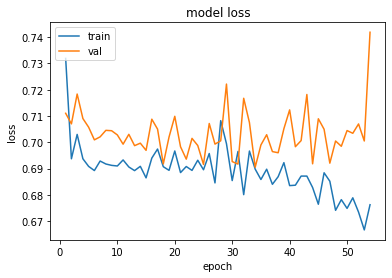

In [24]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

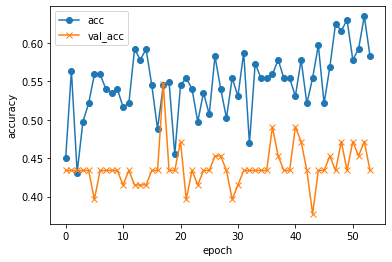

In [25]:
#acc, val_accのプロット
plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
#Final.pngという名前で、結果を保存
# plt.savefig('Final.png')
# plt.show()

In [26]:
print("Test accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

65/65 [==============================] - 0s 130us/step
Test accuracy: 0.6462


In [27]:
predict_classes = model.predict_classes(X_test)

In [28]:
Y_test = np.array([np.argmax(x) for x in Y_test])

In [29]:
pd.crosstab(Y_test, predict_classes, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,6,23,29
1,0,36,36
All,6,59,65
